# Example Notebook

**This notebook shows the potential of Jupyer Labs for hosting the EDACAB hackathon.**

This project is brought to you through collaboration between the University of Edinburgh & Chongqing University.


<div>
<img src="https://upload.wikimedia.org/wikipedia/en/thumb/7/7a/University_of_Edinburgh_ceremonial_roundel.svg/1200px-University_of_Edinburgh_ceremonial_roundel.svg.png" width="100"/>

<img src="https://upload.wikimedia.org/wikipedia/en/a/af/Chongqing_University_Logo.png" width="100"/>
</div>


We'll start by loading in some commonly used Python modules we need for processing and plotting the data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import requests
import pandas as pd
import urllib  # the lib that handles the url stuff
from scipy.signal import welch


### Loading data

Now let's load the data from GitHub. This data is stored as a list of dictionaries. The code below loads the data and converts it to a nested dictionary.

In [2]:
url = "https://raw.githubusercontent.com/zwynne/EDACAB/main/Chongqing_data/Part_Sensor_record_data_data.txt"


data = urllib.request.urlopen(url).readlines() # it's a file like object and works just like a file

dat = list(map(json.loads, data))[0]

unique_conditions = np.unique([i['Working condition'] for i in dat])
dat0 = {}

for i in range(len(unique_conditions)):
    tmp = {}
    for entry in dat:
        if entry['Working condition']==unique_conditions[i]:
            tmp['Measuring point: '+entry['Measuring point']]=entry
    dat0['Working condition: '+unique_conditions[i]]=tmp
    del(entry,tmp)
del(i,dat,unique_conditions)

### Exploring the data
Let's see what working conditions are included.

In [3]:
working_conditions = list(dat0.keys())
print(working_conditions)

['Working condition: e1', 'Working condition: e2', 'Working condition: e3', 'Working condition: e4']


We'll check which measuing points we have for one of the working conditions.

In [4]:
measuring_points = list(dat0['Working condition: e1'].keys())
print(measuring_points)

['Measuring point: A10', 'Measuring point: A1', 'Measuring point: A2', 'Measuring point: A3', 'Measuring point: A4', 'Measuring point: A5', 'Measuring point: A6', 'Measuring point: A7', 'Measuring point: A8', 'Measuring point: A9', 'Measuring point: AY1', 'Measuring point: AY2', 'Measuring point: AY3', 'Measuring point: AY4', 'Measuring point: AY5', 'Measuring point: AY6', 'Measuring point: AY7', 'Measuring point: AZ2', 'Measuring point: AZ3', 'Measuring point: AZ4', 'Measuring point: AZ5', 'Measuring point: AZ6', 'Measuring point: AZ7', 'Measuring point: E11', 'Measuring point: E12', 'Measuring point: E13', 'Measuring point: E14', 'Measuring point: E15', 'Measuring point: E16', 'Measuring point: E17', 'Measuring point: E18', 'Measuring point: R1', 'Measuring point: R2']


### Plotting data

Now let's plot all the Z direction measuring points measured responses alongside their Welch Power Spectral Density!

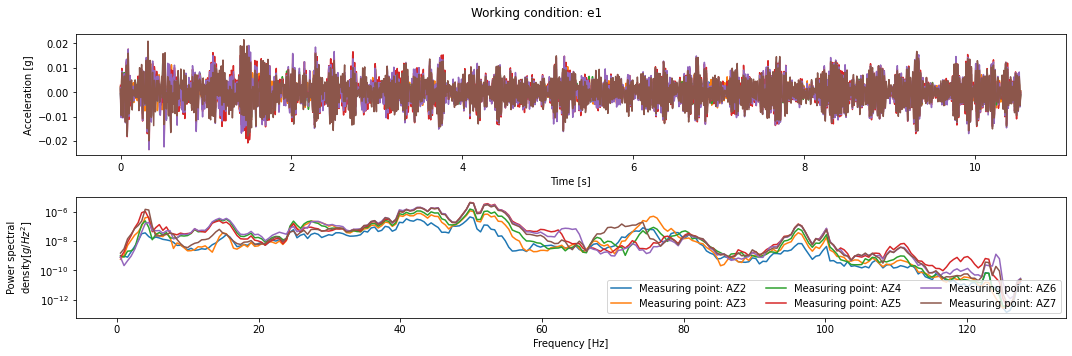

In [5]:
condition = 'Working condition: e1'

fg,ax = plt.subplots(2,figsize=(15,5))
for channel in measuring_points:
    f,psd = welch(dat0[condition][channel]['Acceleration'],fs=255.1,nperseg=512)
    channel_name = channel.split()[-1]
    if "Z" in channel_name:
        ax[0].plot(dat0[condition][channel]['Time [s]'],dat0[condition][channel]['Acceleration'],label=channel)
        ax[1].semilogy(f[1:],psd[1:],label=channel)
ax[0].set_ylabel('Acceleration [g]')
ax[1].set_ylabel('Power spectral\ndensity[$g/Hz^2$]')
ax[0].set_xlabel('Time [s]')
ax[1].set_xlabel('Frequency [Hz]')
ax[1].legend(loc=4,ncol=3)
fg.suptitle(condition)
fg.tight_layout()

## Accessing data from other data sources

We'll now try accessing data that is stored on the Dryad research data repository (https://datadryad.org/stash). This data set contains accelerometer data from a white stork performing various movements. 

In [6]:
url = "https://datadryad.org/stash/downloads/file_stream/794664"
stork_dat=pd.read_csv(url,header=None)

This data format is a bit of a mess, let's rename the columns with the a numerical counter.

In [7]:
stork_dat.columns = ['Stork ' +str(j) for j in range(len(stork_dat.iloc[-1]))]
stork_dat.drop(stork_dat.columns[-1], axis=1, inplace=True) # Last column has notes so we'll drop it
# stork_dat.columns.tolist()[:10] # Print the first ten column headers
stork_dat[stork_dat.columns[-1]]

0      -12.450335
1       -9.966067
2      -13.644817
3      -10.545749
4       -6.309613
          ...    
1741    -9.396124
1742    -9.261894
1743   -10.389681
1744   -10.099840
1745   -10.077544
Name: Stork 119, Length: 1746, dtype: float64

Now let's plot some of the data.

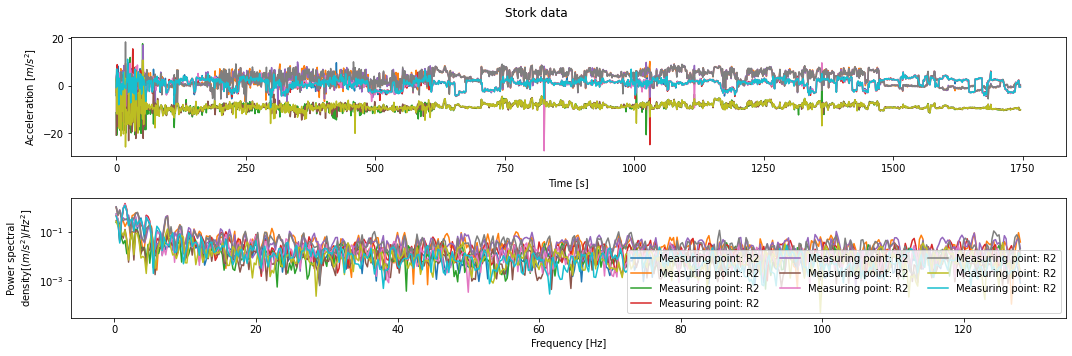

In [8]:
fg,ax = plt.subplots(2,figsize=(15,5))
for dataset_name in stork_dat.columns[:10]:
    f,psd = welch(stork_dat[dataset_name],fs=256,nperseg=1024)
    ax[0].plot(stork_dat[dataset_name])
    ax[1].semilogy(f[1:],psd[1:],label=channel)
ax[0].set_ylabel('Acceleration [$m/s^2$]')
ax[1].set_ylabel('Power spectral\ndensity[$(m/s^2)/Hz^2$]')
ax[0].set_xlabel('Time [s]')
ax[1].set_xlabel('Frequency [Hz]')
ax[1].legend(loc=4,ncol=3)
fg.suptitle('Stork data')
fg.tight_layout()

## Connecting to the LT2 Bridge via a websocket

Now let's try connecting to the LT2 Smart Bridge via it's websocket. We'll begin by loading in the socketio package.

In [9]:
import socketio
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import numpy as np
import matplotlib.pyplot as plt
import time

Now we'll define the websocket client we're trying to connect to and the event handlers that will let us connect to that client.

In [10]:
dat = 0
t = 0
sio = socketio.Client()
@sio.event
def connect():
    print("I'm connected!")

@sio.event
def connect_error(data):
    print("The connection failed!")

@sio.event
def disconnect():
    print("I'm disconnected!")


@sio.on('my response')
def direct_from_server(message):
    global dat,t 
    message = message.split(';')[1]
    message = message.split(',')
    message = filter(None, message)
    dat = np.array(list(map(float, message)))
    t = np.arange(len(dat))/1024
    
    


To connect to the data stream we use the connect function, pointed at the smarterbridge website.

In [11]:
sio.connect('https://smarterbridge.herokuapp.com/')

I'm connected!


To disconnect from the data stream we use the disconnect function.

In [12]:
sio.disconnect()

I'm disconnected!


Now let's plot the data that streaming to the notebook!

I'm disconnected!


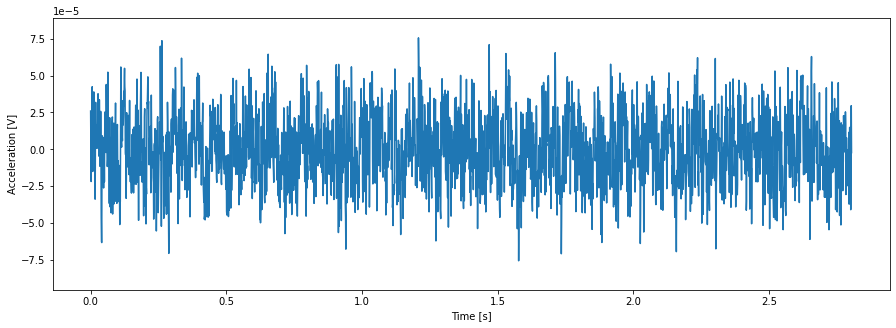

In [14]:
sio.connect('https://smarterbridge.herokuapp.com/')
clear_output(wait=True)
fg,ax = plt.subplots(figsize=(15,5))
ax.set_ylabel('Acceleration [V]')
ax.set_xlabel('Time [s]')
plt_dat, = ax.plot(t,dat)
for _ in range(10):
    
    
    display(plt.gcf())
    clear_output(wait=True)
    
    plt_dat.set_ydata(dat)
    time.sleep(0.1)

sio.disconnect()